In [ ]:
!apt update && apt install -y openslide-tools
!pip install openslide-python
!pip install tiatoolbox


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torchvision
import torch.distributions as torchdist
import torch.nn as nn
import time
from PIL import Image, ImageOps, ImageFilter
import random
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import os
import openslide
import cv2
import random


# Non-RL Part

## Masking Method

Extracted: 690  patches total. Here are 100


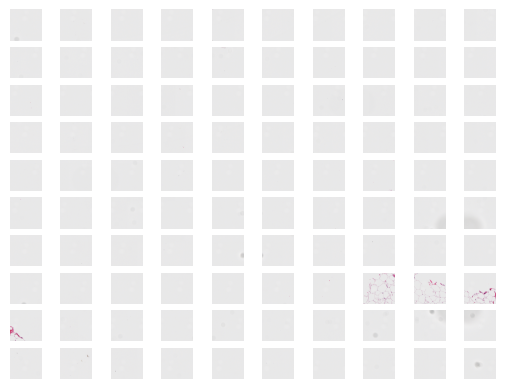

In [ ]:
from tiatoolbox.tools import patchextraction
from tiatoolbox.tools.tissuemask import MorphologicalMasker
from tiatoolbox.wsicore.wsireader import WSIReader

wsi = WSIReader.open(input_img="/content/05000664-00816069-23HI010966-1-A27-1.ndpi")

patch_extractor = patchextraction.get_patch_extractor(
    input_img=wsi,
    method_name="slidingwindow",
    patch_size=(512,512,),
    resolution=1,
    units="level",
)

i = 1
num_patches_to_show = 100
print("Extracted:", len(patch_extractor), " patches total. Here are 100")

for patch in patch_extractor:
    plt.subplot(10, 10, i)
    plt.imshow(patch)
    plt.axis("off")
    if i >= num_patches_to_show:
        break
    i += 1
plt.show()

masker = MorphologicalMasker(min_region_size=30)
masks = masker.fit_transform(patch_extractor)
patch_extractor = [patch_extractor[i] for i in range(len(patch_extractor)) if not np.all(masks[i] == False)]


# Get the set of patches and mask 1 by one
# If that patch is fully masked out, we can decide not to save it
# Afterwards, we save only those that passed

# https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/03-tissue-masking.ipynb

In [ ]:
i = 1
slidepath = "/content/05000664-00816069-23HI010966-1-A27-1.ndpi"
slideName = slidepath.split("/")[-1]
rootDir = "/content/Output"
imageOutputPath = str(rootDir+"/"+slideName+"/")
os.mkdir(imageOutputPath)
for patch in patch_extractor:
  print(str(imageOutputPath+str(i)+".jpg"))
  cv2.imwrite(str(imageOutputPath+str(i)+".jpg"),patch)
  i = i+1

True


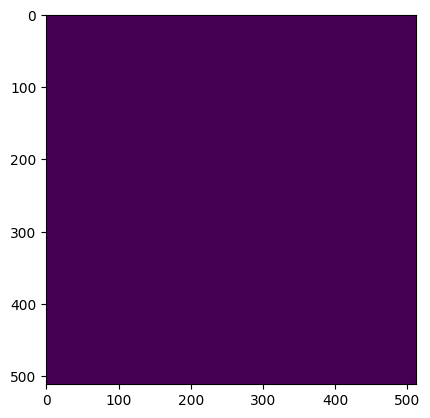

In [ ]:
plt.imshow(masks[0])
print(np.all(masks[0] == False))

## Preparing Slides with the modified WSI Reader

Note: This is only needed for patches in which the X,Y position on the slide will be used.

In [ ]:
from TIAToolbox_WSIReader_Modified import WSIReader

In [ ]:
from tiatoolbox.wsicore.wsireader import WSIReader

In [ ]:
wsiReader = WSIReader.open(input_img='/content/normal_019.tif')
#wsiReader.save_tiles(output_dir='/content/workspace', tile_objective_value=10, tile_read_size=(512,512))

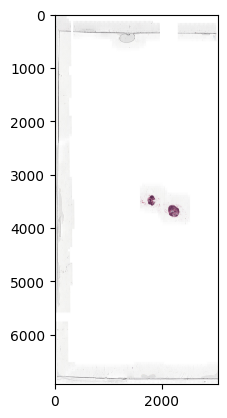

In [ ]:
plt.imshow(wsiReader.slide_thumbnail())

### Preparing the Grid from WSIs without Masking

In [ ]:
import os
import numpy as np
import PIL
from PIL import Image

def flood_fill_iterative(c, r, grid, mask):
    """Iterative flood fill for RGB grid using a stack."""
    stack = [(c, r)]
    rows, cols, _ = grid.shape

    while stack:
        x, y = stack.pop()
        if x < 0 or x >= cols or y < 0 or y >= rows or mask[y, x] or not np.all(grid[y, x] != [0,0,0]):
            continue

        mask[y, x] = True  # Mark this cell as visited

        # Add neighboring cells to stack
        stack.append((x + 1, y))
        stack.append((x - 1, y))
        stack.append((x, y + 1))
        stack.append((x, y - 1))

# pathToPatches assumes the the path has form: C:\\...\\...\\... and is a folder containing patches created using TIAToolbox
# patchSize assumes square patches and thus takes a single int as input

def stitchPatches(pathToPatches, patchSize, outputDir):

    fileName = pathToPatches.split("\\")[-1]
    slide = fileName.split("/")[-1]
    patch_files = [os.path.join(pathToPatches, file) for file in (os.listdir(pathToPatches)[3:]) if file.endswith('.jpg')]

    # Create a dict mapping each x,y coordinate to the given patches path
    # Additionally stores the maximum x and y coordinates to know the final size of the image
    max_x = 0
    max_y = 0
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        max_x = max(max_x, x)
        max_y = max(max_y, y)

    stitched_img = np.empty((max_y + patchSize, max_x + patchSize, 3), dtype=np.uint8)

    # Creating the full array representing the original image
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        with Image.open(patch) as img:
            patch_array = np.array(img)

            # Check the shape and pad if necessary
            if patch_array.shape != (patchSize, patchSize, 3):
                padded_patch = np.zeros((patchSize, patchSize, 3), dtype=np.uint8)
                padded_patch[:patch_array.shape[0], :patch_array.shape[1]] = patch_array
                patch_array = padded_patch

            stitched_img[y:y + patchSize, x:x + patchSize] = patch_array

  # # Removing patches that can not link to the main object
  #   rows, cols, _ = stitched_img.shape
  #   mask = np.zeros((rows, cols), dtype=bool)

  #   # Assuming a central patch starts filled (not black)
  #   central_r, central_c = rows // 2, cols // 2

  #   # Start iterative flood fill from the center
  #   flood_fill_iterative(central_c, central_r, stitched_img, mask)

  #   # Blank out unconnected patches
  #   for r in range(rows):
  #       for c in range(cols):
  #           if not mask[r, c]:  # If not visited
  #               stitched_img[r, c] = [0, 0, 0]  # Set to black

    # Saving the final image
    im = Image.fromarray(stitched_img)
    outPath = os.path.join(outputDir, f"WSIGRID_{slide}.jpeg")
    im.save(outPath)

    del stitched_img  # Clear large objects explicitly
    return "All Images Have Been Created"

def stitchSlide(pathToPatches, patchSize):
    fileName = pathToPatches.split("\\")[-1]
    slide = fileName.split("/")[-1]
    patch_files = [os.path.join(pathToPatches, file) for file in (os.listdir(pathToPatches)[3:]) if file.endswith('.jpg')]

    # Create a dict mapping each x,y coordinate to the given patches path
    # Additionally stores the maximum x and y coordinates to know the final size of the image
    max_x = 0
    max_y = 0
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        max_x = max(max_x, x)
        max_y = max(max_y, y)

    stitched_img = np.empty((max_y + patchSize, max_x + patchSize, 3), dtype=np.uint8)

    # Creating the full array representing the original image
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        with Image.open(patch) as img:
            patch_array = np.array(img)

            # Check the shape and pad if necessary
            if patch_array.shape != (patchSize, patchSize, 3):
                padded_patch = np.zeros((patchSize, patchSize, 3), dtype=np.uint8)
                padded_patch[:patch_array.shape[0], :patch_array.shape[1]] = patch_array
                patch_array = padded_patch

            stitched_img[y:y + patchSize, x:x + patchSize] = patch_array

    return stitched_img



# stitchPatches(pathToPatches='/content/PatchOut/00000664-00793767-23HI012153-1-A26-1.ndpi',
#                patchSize=512, outputDir='/content/PatchOut/00000664-00793767-23HI012153-1-A26-1.ndpi')

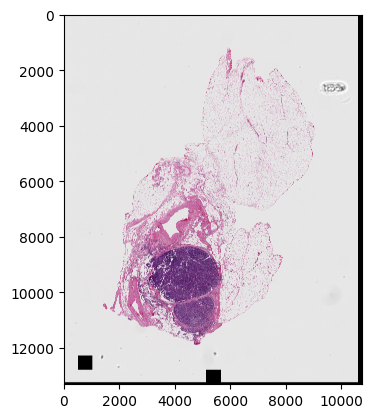

In [ ]:
slide = stitchSlide("/content/PatchOut/00000664-00793767-23HI012153-1-A26-1.ndpi", patchSize=512)
plt.imshow(slide)

# RL

In [ ]:
def stitchSlide(pathToPatches, patchSize):
    fileName = pathToPatches.split("\\")[-1]
    slide = fileName.split("/")[-1]
    patch_files = [os.path.join(pathToPatches, file) for file in (os.listdir(pathToPatches)[3:]) if file.endswith('.jpg')]

    # Create a dict mapping each x,y coordinate to the given patches path
    # Additionally stores the maximum x and y coordinates to know the final size of the image
    max_x = 0
    max_y = 0
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        max_x = max(max_x, x)
        max_y = max(max_y, y)

    stitched_img = np.empty((max_y + patchSize, max_x + patchSize, 3), dtype=np.uint8)

    # Creating the full array representing the original image
    for patch in patch_files:
        patchName = os.path.basename(patch).split(".")[0]
        if(patchName == "slide_thumbnail"):
          continue
        x, y = map(int, patchName.split("_")[-2:])
        with Image.open(patch) as img:
            patch_array = np.array(img)

            # Check the shape and pad if necessary
            if patch_array.shape != (patchSize, patchSize, 3):
                padded_patch = np.zeros((patchSize, patchSize, 3), dtype=np.uint8)
                padded_patch[:patch_array.shape[0], :patch_array.shape[1]] = patch_array
                patch_array = padded_patch

            stitched_img[y:y + patchSize, x:x + patchSize] = patch_array

    return stitched_img

In [ ]:
path1 = "/content/data"
path2 = "/content/data2"

allSlides = []
path1List = os.listdir(path1)
path2List = os.listdir(path2)

for path in path1List:
  allSlides.append(str(path1 + "/" + path))

# for path in path2List:
#   allSlides.append(str(path2 + "/" + path))


allSlides = allSlides[:-1]

print(allSlides)

['/content/data/00000664-00803861-23HI013142-1-A25-1.ndpi']


## Actor-Critic Policy - Single Patch Input

In [ ]:
from tiatoolbox.wsicore.wsireader import WSIReader

class SlideGridEnv():

  def __init__(self, slideList, patchSize, magnification, workspacePath):
    self.slideList = slideList
    self.currentSlide = 0
    self.patch_size = patchSize
    self.magnification_level = magnification
    self.workspacePath = workspacePath
    self.currentGrid = 0
    self.currentState = (0,0)
    self.prevState = None
    self.currentBaseline = 0
    self.visitedStates = []


  def getGrid(self):
    return self.currentGrid

  def reset(self):

    # Switch WSI
    try:
      currentSlidePath = str(self.slideList[self.currentSlide])
    except IndexError:
      state = None
      episodeEnd = True
      print("-----Episode Ended IDX -----")
      return state, episodeEnd
    self.currentState = (0,0)
    self.prevState = (0,0)
    self.visitedStates = []
    episodeEnd = False

    # Generate Current Grid
    wsiReader = WSIReader.open(input_img=currentSlidePath)
    try:
      wsiReader.save_tiles(output_dir=self.workspacePath, tile_objective_value=self.magnification_level, tile_read_size=(512,512))
    except FileExistsError:
      pass
    self.currentGrid = stitchSlide(str(self.workspacePath + "/" + self.slideList[self.currentSlide].split("/")[-1]), self.patch_size[0])
    self.terminalState = (int(self.currentGrid.shape[0]/self.patch_size[0]), int(self.currentGrid.shape[1]/self.patch_size[1]))
    print("TSTATE", self.terminalState)

    # Get initial state
    state = self.currentGrid[self.currentState[0]:self.patch_size[0],self.currentState[1]:self.patch_size[1]]

    # Generate the baseline for comparison
    self.currentBaseline = np.mean(state[:,:,:], axis=(0,1))

    # Prepare the Next Slide
    self.currentSlide = self.currentSlide + 1

    print("NEW SLIDE - SHAPE:", self.currentGrid.shape)

    return state, episodeEnd

  def generateReward(self, state, done):
    # If Out-of-Bounds
    if done == True:
      reward = -100
      done = True
      return reward, done

    stateRGB = np.mean(state[:,:,:], axis=(0,1))
    if stateRGB[0]<self.currentBaseline[0]-3 and stateRGB[1]<self.currentBaseline[1]-3 and stateRGB[2]<self.currentBaseline[2]-3:
        reward = 1
    else:
        reward = -1

    done = False
    return reward, done

  def moveSpace(self,moveTuple):
    # Track Visited
    self.visitedStates.append(self.currentState)
    self.prevState = self.currentState
    print("Current", self.currentState, "MOVETUPLE", moveTuple)
    self.currentState = (self.currentState[0]+moveTuple[0], self.currentState[1]+moveTuple[1])
    print("NEW CURRENT", self.currentState)
    return self.currentState

  def step(self, action):
    print("BEFORE STEP VISITED", self.visitedStates)

    # Save the current state to see if we moved out of bounds
    self.prevState = self.currentState
    done = False

    # Remove Action from list in the case where it was an e-greedy random action
    if (type(action) == list):
      action = action[0]

    # Move to the next patch
    if action == 0:         # Up
      if self.currentState == self.terminalState or self.currentState[0] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, 0))
    elif action == 1:       # Down
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, 0))
    elif action == 2:       # Left
      if self.currentState == self.terminalState or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((0, -1))
    elif action == 3:       # Right
      if self.currentState == self.terminalState or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((0, 1))
    elif action == 4:       # Up-Left
      if self.currentState == self.terminalState or self.currentState[0] <= 0 or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, -1))
    elif action == 5:       # Up-Right
      if self.currentState == self.terminalState or self.currentState[0] <= 0 or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, 1))
    elif action == 6:       # Down-Left
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0] or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, -1))
    elif action == 7:       # Down-Right
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0] or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, 1))

    # After moving, get the state
    print("info", self.currentState[0]*self.patch_size[0], self.currentState[0]*self.patch_size[0]+self.patch_size[0], self.currentState[1]*self.patch_size[1], self.currentState[1]*self.patch_size[1]+self.patch_size[1],)
    state = self.currentGrid[self.currentState[0]:self.currentState[0]+self.patch_size[0],self.currentState[1]:self.currentState[1]+self.patch_size[1]]
    if self.prevState is None:
      prevState = self.currentGrid[self.currentState[0]:abs(self.currentState[0]+self.patch_size[0]),self.currentState[1]:abs(self.currentState[1]+self.patch_size[1])]
    else:
      prevState = self.currentGrid[self.prevState[0]:self.prevState[0]+self.patch_size[0],self.prevState[1]:self.prevState[1]+self.patch_size[1]]

  ## Get reward
    # Hit the edge
    if done == True:
      reward = -100
    if self.currentState == self.terminalState:
      done = True
      reward = 0
    elif (self.currentState == (0,0) and self.currentState in self.visitedStates):
      done = True
      reward = -200
    elif self.currentState in self.visitedStates:
      reward = -10
      done = False
    else:
      reward, done = self.generateReward(state, done)

    return state, reward, done

In [ ]:
class TissueSearchAgent():
    def __init__(
        self,
        discount=0.90,
        epsilon=0.8,
        name="Actor-Critic",
    ):

      resnet_backbone = torchvision.models.resnet18(pretrained=True)
      self.replace_batchnorm_with_identity(resnet_backbone)
      # for layer in list(resnet_backbone.children()):
      #   print(layer)
      modulesPolicy = list(resnet_backbone.children())[:-1]
      modulesValue = list(resnet_backbone.children())[:-1]

      self.resnet_backboneP = nn.Sequential(*modulesPolicy)
      self.output_layerP = nn.Sequential(nn.Linear(512, 8), nn.Softmax())
      self.resnet_backboneV = nn.Sequential(*modulesValue)
      self.output_layerV = nn.Linear(1,1)

      self.policy_network = torch.nn.Sequential(self.resnet_backboneP, self.output_layerP)
      self.opt = torch.optim.Adam(self.policy_network.parameters(), lr=0.0004)
      self.value_network = torch.nn.Sequential(self.resnet_backboneV, self.output_layerV)
      self.value_opt = torch.optim.Adam(self.value_network.parameters(), lr=0.0004)

      self.discount = discount
      self.epsilon = epsilon

    # Because we are only passing 1 patch at a time to the models,
    # we do not have to have any batchnorm effect
    # This can cause instability in the model.
    # We opt to replace the BN layers from the pretrained model with Identity.
    def replace_batchnorm_with_identity(self, model):
      for child_name, child in model.named_children():
          if isinstance(child, torch.nn.BatchNorm2d):
              # Replace the BatchNorm layer with Identity
              setattr(model, child_name, torch.nn.Identity())
          else:
              # Otherwise, proceed to replace in child modules
              self.replace_batchnorm_with_identity(child)

    def forward(self, state):
      x = state.clone().unsqueeze(0)
      x = torch.transpose(x, 1, 3)
      x = self.resnet_backboneP(x)
      y = x.view(x.size(0), -1)  # Flatten the output
      z = self.output_layerP(y)
      return z

    def distribution(self, state):
      probs = self.forward(state)
      dist = torchdist.categorical.Categorical(probs=probs)
      return dist

    def action(self, state):

      if random.random() < self.epsilon:
        action = random.sample([0,1,2,3,4,5,6,7],1)
        print(action)
        return action

      dist = self.distribution(state)
      action = dist.sample()
      print(action)
      action = action.item()
      return action

    def train_episode(self, env) -> float:
        loss_dict = {}

        episodeEnd = False
        while not episodeEnd:
          done = False
          loss_dict["policy_loss"] = 0
          loss_dict["value_loss"] = 0
          cumRewards = []
          t = 0
          I = 1
          state, episodeEnd = env.reset()
          if (episodeEnd):
            break
          cumulativeReward = 0
          while not done:
            print("NEW STEP --")
            state = torch.tensor(state, dtype=torch.float32)
            # Get action
            action = self.action(state)
            # Get state value
            valueState = torch.transpose(state.unsqueeze(0), 1,3)
            stateValue = self.value_network(valueState).detach()
            # Take step
            stateNextPre, reward, done = env.step(action)
            stateNext = torch.tensor(stateNextPre, dtype=torch.float32)
            cumulativeReward += reward
            if t >= 20:
              done = True
            print("REWARD", reward)
            # Next State Value
            if not done:
              inputState = torch.transpose(stateNext.unsqueeze(0), 1,3)
              stateValueNext = self.value_network(inputState).detach() # Detach for stop_gradient
            else:
              stateValueNext = torch.zeros_like(stateValue)
              print("CUM REWARD", cumulativeReward)
            # State Action Prob
            prob = self.distribution(state).log_prob(torch.tensor(action, dtype=torch.float32))
            # Losses
            policyInner = reward + (self.discount*stateValueNext.detach()) - stateValue
            policyLoss = -policyInner*prob*I
            valueLoss = torch.nn.functional.mse_loss(stateValue, (reward + (self.discount*stateValueNext.detach())))/2
            # Updates
            self.opt.zero_grad()
            pLossSum = policyLoss.sum()
            pLossSum.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=2.0)
            self.opt.step()
            self.value_opt.zero_grad()
            valueForGrad = torch.tensor([valueLoss.item()], requires_grad=True)
            valueForGrad.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm=2.0)
            self.value_opt.step()
            # Track
            loss_dict["policy_loss"] += pLossSum.item()
            loss_dict["value_loss"] += valueForGrad.item()
            # Loop Updates
            state = stateNext
            state = np.array(state)
            t += 1
            I = I*self.discount


          loss_dict["policy_loss"] /= t
          loss_dict["value_loss"] /= t
          print("PD",loss_dict["policy_loss"])
          print("LD",loss_dict["value_loss"])
          loss_dict["reward"] = cumulativeReward
          #cumRewards.append(cumulativeReward)

        return loss_dict

In [ ]:
rewards = []
myEnv = SlideGridEnv(allSlides, patchSize=(512,512,), magnification=10, workspacePath="/content/workspace")
#pNet = policy_network()
myAgent = TissueSearchAgent()
numEpochs = 100
for epoch in range(numEpochs):
  loss_dict = myAgent.train_episode(myEnv)
  #print("FROM DICT:", loss_dict["reward"])
  rewards.append(loss_dict["reward"])
  myEnv = SlideGridEnv(allSlides, patchSize=(512,512,), magnification=10, workspacePath="/content/workspace")

# FIX
# NOT LEARNING

TSTATE (24, 23)
NEW SLIDE - SHAPE: (12288, 11776, 3)
NEW STEP --
tensor([6])
BEFORE STEP VISITED []
info 0 512 0 512
REWARD -100
CUM REWARD -100
PD -0.0070778680965304375
LD 7747.00439453125
-----Episode Ended IDX -----
TSTATE (24, 23)
NEW SLIDE - SHAPE: (12288, 11776, 3)
NEW STEP --
[3]
BEFORE STEP VISITED []
Current (0, 0) MOVETUPLE (0, 1)
NEW CURRENT (0, 1)
info 0 512 512 1024
REWARD -1
NEW STEP --
[2]
BEFORE STEP VISITED [(0, 0)]
Current (0, 1) MOVETUPLE (0, -1)
NEW CURRENT (0, 0)
info 0 512 0 512
REWARD -200
CUM REWARD -201
PD -803858.4453125
LD 12176.584795951843
-----Episode Ended IDX -----
TSTATE (24, 23)
NEW SLIDE - SHAPE: (12288, 11776, 3)
NEW STEP --
[2]
BEFORE STEP VISITED []
info 0 512 0 512
REWARD -100
CUM REWARD -100
PD -946554.5
LD 7747.00439453125
-----Episode Ended IDX -----
TSTATE (24, 23)
NEW SLIDE - SHAPE: (12288, 11776, 3)
NEW STEP --
[7]
BEFORE STEP VISITED []
Current (0, 0) MOVETUPLE (1, 1)
NEW CURRENT (1, 1)
info 512 1024 512 1024
REWARD -1
NEW STEP --
[3]
BEFO

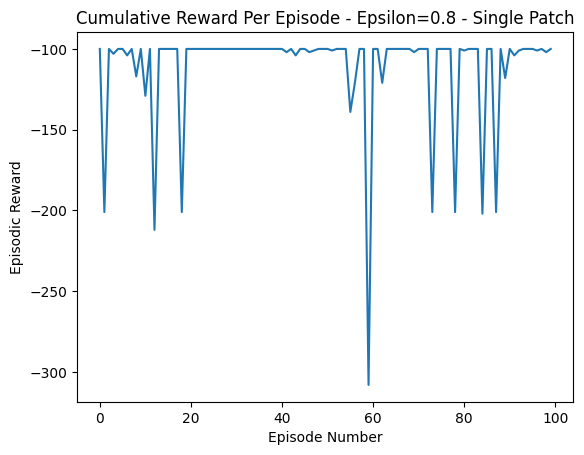

In [ ]:
rewardsTrue = [i for i in rewards]
plt.plot(np.arange(0,numEpochs), rewards)
plt.title("Cumulative Reward Per Episode - Epsilon=0.8 - Single Patch")
plt.xlabel("Episode Number")
plt.ylabel("Episodic Reward")
plt.savefig("/content/Output/CumReward-0.8-Single.")

## Actor-Critic Policy - 2 Patch Input

In [ ]:
from tiatoolbox.wsicore.wsireader import WSIReader

class SlideGridEnv1():

  def __init__(self, slideList, patchSize, magnification, workspacePath):
    self.slideList = slideList
    self.currentSlide = 0
    self.patch_size = patchSize
    self.magnification_level = magnification
    self.workspacePath = workspacePath
    self.currentGrid = 0
    self.currentState = (0,0)
    self.prevState = None
    self.currentBaseline = 0
    self.visitedStates = []


  def getGrid(self):
    return self.currentGrid

  def reset(self):

    # Switch WSI
    try:
      currentSlidePath = str(self.slideList[self.currentSlide])
    except IndexError:
      state = None
      episodeEnd = True
      print("-----Episode Ended IDX -----")
      return state, episodeEnd
    self.currentState = (0,0)
    self.prevState = (0,0)
    self.visitedStates = []
    episodeEnd = False

    # Generate Current Grid
    wsiReader = WSIReader.open(input_img=currentSlidePath)
    try:
      wsiReader.save_tiles(output_dir=self.workspacePath, tile_objective_value=self.magnification_level, tile_read_size=(self.patch_size[0],self.patch_size[1]))
    except FileExistsError:
      pass
    self.currentGrid = stitchSlide(str(self.workspacePath + "/" + self.slideList[self.currentSlide].split("/")[-1]), self.patch_size[0])
    self.terminalState = (int(self.currentGrid.shape[0]/self.patch_size[0]), int(self.currentGrid.shape[1]/self.patch_size[1]))
    print("TSTATE", self.terminalState)

    # Get initial state
    state = self.currentGrid[self.currentState[0]:self.patch_size[0],self.currentState[1]:self.patch_size[1]]

    # Generate the baseline for comparison
    self.currentBaseline = np.mean(state[:,:,:], axis=(0,1))

    # Prepare the Next Slide
    self.currentSlide = self.currentSlide + 1

    print("NEW SLIDE - SHAPE:", self.currentGrid.shape)

    firstState = torch.cat((torch.tensor(state), torch.tensor(state)), 2)

    return firstState, episodeEnd

  def generateReward(self, state, done):
    # If Out-of-Bounds
    if done == True:
      reward = -100
      done = True
      return reward, done

    stateRGB = np.mean(state[:,:,:], axis=(0,1))
    if stateRGB[0]<self.currentBaseline[0]-3 and stateRGB[1]<self.currentBaseline[1]-3 and stateRGB[2]<self.currentBaseline[2]-3:
        reward = 1
    else:
        reward = -1

    done = False
    return reward, done

  def moveSpace(self,moveTuple):
    # Track Visited
    self.visitedStates.append(self.currentState)
    self.prevState = self.currentState
    print("Current", self.currentState, "MOVETUPLE", moveTuple)
    self.currentState = (self.currentState[0]+moveTuple[0], self.currentState[1]+moveTuple[1])
    print("NEW CURRENT", self.currentState)
    return self.currentState

  def step(self, action):
    print("BEFORE STEP VISITED", self.visitedStates)

    # Save the current state to see if we moved out of bounds
    self.prevState = self.currentState
    done = False

    # Remove Action from list in the case where it was an e-greedy random action
    if (type(action) == list):
      action = action[0]

    # Move to the next patch
    if action == 0:         # Up
      if self.currentState == self.terminalState or self.currentState[0] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, 0))
    elif action == 1:       # Down
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, 0))
    elif action == 2:       # Left
      if self.currentState == self.terminalState or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((0, -1))
    elif action == 3:       # Right
      if self.currentState == self.terminalState or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((0, 1))
    elif action == 4:       # Up-Left
      if self.currentState == self.terminalState or self.currentState[0] <= 0 or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, -1))
    elif action == 5:       # Up-Right
      if self.currentState == self.terminalState or self.currentState[0] <= 0 or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, 1))
    elif action == 6:       # Down-Left
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0] or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, -1))
    elif action == 7:       # Down-Right
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0] or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, 1))

    # After moving, get the state
    print("info", self.currentState[0]*self.patch_size[0], self.currentState[0]*self.patch_size[0]+self.patch_size[0], self.currentState[1]*self.patch_size[1], self.currentState[1]*self.patch_size[1]+self.patch_size[1],)
    state = self.currentGrid[self.currentState[0]:self.currentState[0]+self.patch_size[0],self.currentState[1]:self.currentState[1]+self.patch_size[1]]
    if self.prevState is None:
      prevState = self.currentGrid[self.currentState[0]:abs(self.currentState[0]+self.patch_size[0]),self.currentState[1]:abs(self.currentState[1]+self.patch_size[1])]
    else:
      prevState = self.currentGrid[self.prevState[0]:self.prevState[0]+self.patch_size[0],self.prevState[1]:self.prevState[1]+self.patch_size[1]]

    # Contatenating to pass the current state and previous one
    stateTotal = torch.cat((torch.tensor(state), torch.tensor(prevState)), 2)

  ## Get reward
    # Hit the edge
    if done == True:
      reward = -100
    if self.currentState == self.terminalState:
      done = True
      reward = 0
    elif (self.currentState == (0,0) and self.currentState in self.visitedStates):
      done = True
      reward = -200
    elif self.currentState in self.visitedStates:
      reward = -10
      done = False
    else:
      reward, done = self.generateReward(state, done)

    return stateTotal, reward, done

In [ ]:
class TissueSearchAgent1():
    def __init__(
        self,
        discount=0.90,
        epsilon=0.8,
        name="Actor-Critic",
    ):

      resnet_backbone = torchvision.models.resnet18(pretrained=True)
      self.replace_batchnorm_with_identity(resnet_backbone)
      # for layer in list(resnet_backbone.children()):
      #   print(layer)
      modulesPolicy = list(resnet_backbone.children())[:-1]
      modulesPolicy[0] = nn.Conv2d(6,64,(7,7),(2,2),(3,3),bias=False)
      modulesValue = list(resnet_backbone.children())[:-1]
      modulesValue[0] = nn.Conv2d(6,64,(7,7),(2,2),(3,3),bias=False)

      self.resnet_backboneP = nn.Sequential(*modulesPolicy)
      self.output_layerP = nn.Sequential(nn.Linear(512, 8), nn.Softmax())
      self.resnet_backboneV = nn.Sequential(*modulesValue)
      self.output_layerV = nn.Linear(1,1)

      self.policy_network = torch.nn.Sequential(self.resnet_backboneP, self.output_layerP)
      self.opt = torch.optim.Adam(self.policy_network.parameters(), lr=0.0004)
      self.value_network = torch.nn.Sequential(self.resnet_backboneV, self.output_layerV)
      self.value_opt = torch.optim.Adam(self.value_network.parameters(), lr=0.0004)

      self.discount = discount
      self.epsilon = epsilon

    # Because we are only passing 1 patch at a time to the models,
    # we do not have to have any batchnorm effect
    # This can cause instability in the model.
    # We opt to replace the BN layers from the pretrained model with Identity.
    def replace_batchnorm_with_identity(self, model):
      for child_name, child in model.named_children():
          if isinstance(child, torch.nn.BatchNorm2d):
              # Replace the BatchNorm layer with Identity
              setattr(model, child_name, torch.nn.Identity())
          else:
              # Otherwise, proceed to replace in child modules
              self.replace_batchnorm_with_identity(child)

    def forward(self, state):
      x = state.clone().unsqueeze(0)
      x = torch.transpose(x, 1, 3)
      x = self.resnet_backboneP(x)
      y = x.view(x.size(0), -1)  # Flatten the output
      z = self.output_layerP(y)
      return z

    def distribution(self, state):
      probs = self.forward(state)
      dist = torchdist.categorical.Categorical(probs=probs)
      return dist

    def action(self, state):

      if random.random() < self.epsilon:
        action = random.sample([0,1,2,3,4,5,6,7],1)
        print(action)
        return action

      dist = self.distribution(state)
      action = dist.sample()
      print(action)
      action = action.item()
      return action

    def train_episode(self, env) -> float:
        loss_dict = {}

        episodeEnd = False
        while not episodeEnd:
          done = False
          loss_dict["policy_loss"] = 0
          loss_dict["value_loss"] = 0
          cumRewards = []
          t = 0
          I = 1
          state, episodeEnd = env.reset()
          if (episodeEnd):
            break
          cumulativeReward = 0
          while not done:
            print("NEW STEP --")
            state = torch.tensor(state, dtype=torch.float32)
            # Get action
            action = self.action(state)
            # Get state value
            valueState = torch.transpose(state.unsqueeze(0), 1,3)
            stateValue = self.value_network(valueState).detach()
            # Take step
            stateNextPre, reward, done = env.step(action)
            stateNext = torch.tensor(stateNextPre, dtype=torch.float32)
            cumulativeReward += reward
            if t >= 20:
              done = True
            print("REWARD", reward)
            # Next State Value
            if not done:
              inputState = torch.transpose(stateNext.unsqueeze(0), 1,3)
              stateValueNext = self.value_network(inputState).detach() # Detach for stop_gradient
            else:
              stateValueNext = torch.zeros_like(stateValue)
              print("CUM REWARD", cumulativeReward)
            # State Action Prob
            prob = self.distribution(state).log_prob(torch.tensor(action, dtype=torch.float32))
            # Losses
            policyInner = reward + (self.discount*stateValueNext.detach()) - stateValue
            policyLoss = -policyInner*prob*I
            valueLoss = torch.nn.functional.mse_loss(stateValue, (reward + (self.discount*stateValueNext.detach())))/2
            # Updates
            self.opt.zero_grad()
            pLossSum = policyLoss.sum()
            pLossSum.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=2.0)
            self.opt.step()
            self.value_opt.zero_grad()
            valueForGrad = torch.tensor([valueLoss.item()], requires_grad=True)
            valueForGrad.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm=2.0)
            self.value_opt.step()
            # Track
            loss_dict["policy_loss"] += pLossSum.item()
            loss_dict["value_loss"] += valueForGrad.item()
            # Loop Updates
            state = stateNext
            state = np.array(state)
            t += 1
            I = I*self.discount


          loss_dict["policy_loss"] /= t
          loss_dict["value_loss"] /= t
          print("PD",loss_dict["policy_loss"])
          print("LD",loss_dict["value_loss"])
          loss_dict["reward"] = cumulativeReward
          #cumRewards.append(cumulativeReward)

        return loss_dict

In [ ]:
rewards = []
myEnv = SlideGridEnv1(allSlides, patchSize=(1024,1024,), magnification=10, workspacePath="/content/workspace")
#pNet = policy_network()
myAgent = TissueSearchAgent1()
numEpochs = 100
for epoch in range(numEpochs):
  loss_dict = myAgent.train_episode(myEnv)
  #print("FROM DICT:", loss_dict["reward"])
  rewards.append(loss_dict["reward"])
  myEnv = SlideGridEnv1(allSlides, patchSize=(1024,1024,), magnification=10, workspacePath="/content/workspace")

# FIX
# NOT LEARNING

  state = torch.tensor(state, dtype=torch.float32)



TSTATE (12, 12)
NEW SLIDE - SHAPE: (12800, 12288, 3)
NEW STEP --
[5]


  stateNext = torch.tensor(stateNextPre, dtype=torch.float32)



BEFORE STEP VISITED []
info 0 1024 0 1024
REWARD -100
CUM REWARD -100
PD -562792.25
LD 5100.42724609375
-----Episode Ended IDX -----
TSTATE (12, 12)
NEW SLIDE - SHAPE: (12800, 12288, 3)
NEW STEP --
[6]
BEFORE STEP VISITED []
info 0 1024 0 1024
REWARD -100
CUM REWARD -100
PD -824866.6875
LD 5106.27685546875
-----Episode Ended IDX -----
TSTATE (12, 12)
NEW SLIDE - SHAPE: (12800, 12288, 3)
NEW STEP --
[7]
BEFORE STEP VISITED []
Current (0, 0) MOVETUPLE (1, 1)
NEW CURRENT (1, 1)
info 1024 2048 1024 2048
REWARD -1
NEW STEP --
[6]
BEFORE STEP VISITED [(0, 0)]
Current (1, 1) MOVETUPLE (1, -1)
NEW CURRENT (2, 0)
info 2048 3072 0 1024
REWARD -1
NEW STEP --
[7]
BEFORE STEP VISITED [(0, 0), (1, 1)]
Current (2, 0) MOVETUPLE (1, 1)
NEW CURRENT (3, 1)
info 3072 4096 1024 2048
REWARD -1
NEW STEP --
[1]
BEFORE STEP VISITED [(0, 0), (1, 1), (2, 0)]
Current (3, 1) MOVETUPLE (1, 0)
NEW CURRENT (4, 1)
info 4096 5120 1024 2048
REWARD -1
NEW STEP --
[6]
BEFORE STEP VISITED [(0, 0), (1, 1), (2, 0), (3, 1)]
C

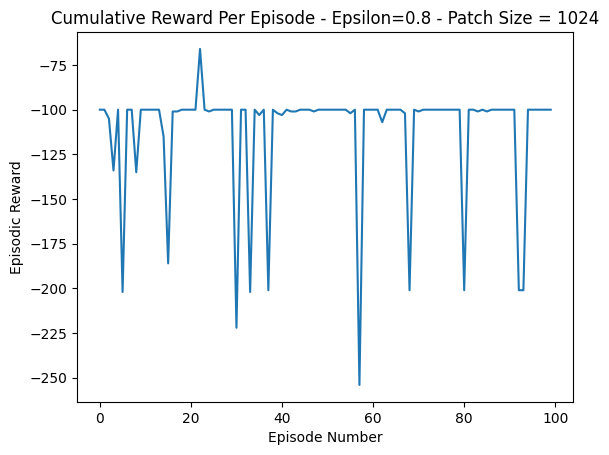

In [ ]:
rewardsTrue = [i for i in rewards]
plt.plot(np.arange(0,numEpochs), rewards)
plt.title("Cumulative Reward Per Episode - Epsilon=0.8 - Patch Size = 1024")
plt.xlabel("Episode Number")
plt.ylabel("Episodic Reward")
plt.savefig("/content/Output/CumReward-0.8-1024.")

## Actor-Critic - 2 Patch + location aware

In [ ]:
from tiatoolbox.wsicore.wsireader import WSIReader

class SlideGridEnv2():

  def __init__(self, slideList, patchSize, magnification, workspacePath):
    self.slideList = slideList
    self.currentSlide = 0
    self.patch_size = patchSize
    self.magnification_level = magnification
    self.workspacePath = workspacePath
    self.currentGrid = 0
    self.currentState = (0,0)
    self.prevState = None
    self.currentBaseline = 0
    self.visitedStates = []



  def getGrid(self):
    return self.currentGrid

  def reset(self):

    # Switch WSI
    try:
      currentSlidePath = str(self.slideList[self.currentSlide])
    except IndexError:
      state = None
      episodeEnd = True
      print("-----Episode Ended IDX -----")
      return state, episodeEnd
    self.currentState = (0,0)
    self.prevState = (0,0)
    self.visitedStates = []
    episodeEnd = False

    # Generate Current Grid
    wsiReader = WSIReader.open(input_img=currentSlidePath)
    try:
      wsiReader.save_tiles(output_dir=self.workspacePath, tile_objective_value=self.magnification_level, tile_read_size=(512,512))
    except openslide.OpenSlideUnsupportedFormatError:
      pass
    except FileExistsError:
      pass

    self.currentGrid = stitchSlide(str(self.workspacePath + "/" + self.slideList[self.currentSlide].split("/")[-1]), self.patch_size[0])
    self.terminalState = (int(self.currentGrid.shape[0]/self.patch_size[0]), int(self.currentGrid.shape[1]/self.patch_size[1]))
    print("TSTATE", self.terminalState)

    # Get initial state
    state = self.currentGrid[self.currentState[0]:self.patch_size[0],self.currentState[1]:self.patch_size[1]]

    # Generate the baseline for comparison
    self.currentBaseline = np.mean(state[:,:,:], axis=(0,1))

    # Prepare the Next Slide
    self.currentSlide = self.currentSlide + 1

    print("NEW SLIDE - SHAPE:", self.currentGrid.shape)

    # Adding the grid info
    gridVisual = torch.zeros([self.terminalState[0], self.terminalState[1]])
    gridVisual[self.currentState[0], self.currentState[1]] = 1
    gridVisual_resized = nn.functional.interpolate(gridVisual.unsqueeze(0).unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=False).squeeze(0)
    gridVisual_resized = torch.transpose(gridVisual_resized, 0,2)

    firstState = torch.cat((torch.tensor(state), torch.tensor(state), gridVisual_resized), 2)

    return firstState, episodeEnd

  def generateReward(self, state, done):
    # If Out-of-Bounds
    if done == True:
      reward = -100
      done = True
      return reward, done

    stateRGB = np.mean(state[:,:,:], axis=(0,1))
    if stateRGB[0]<self.currentBaseline[0]-3 and stateRGB[1]<self.currentBaseline[1]-3 and stateRGB[2]<self.currentBaseline[2]-3:
        reward = 1
    else:
        reward = -1

    done = False
    return reward, done

  def moveSpace(self,moveTuple):
    # Track Visited
    self.visitedStates.append(self.currentState)
    self.prevState = self.currentState
    print("Current", self.currentState, "MOVETUPLE", moveTuple)
    self.currentState = (self.currentState[0]+moveTuple[0], self.currentState[1]+moveTuple[1])
    print("NEW CURRENT", self.currentState)
    return self.currentState

  def step(self, action):
    print("BEFORE STEP VISITED", self.visitedStates)

    # Save the current state to see if we moved out of bounds
    self.prevState = self.currentState
    done = False

    # Remove Action from list in the case where it was an e-greedy random action
    if (type(action) == list):
      action = action[0]

    # Move to the next patch
    if action == 0:         # Up
      if self.currentState == self.terminalState or self.currentState[0] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, 0))
    elif action == 1:       # Down
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, 0))
    elif action == 2:       # Left
      if self.currentState == self.terminalState or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((0, -1))
    elif action == 3:       # Right
      if self.currentState == self.terminalState or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((0, 1))
    elif action == 4:       # Up-Left
      if self.currentState == self.terminalState or self.currentState[0] <= 0 or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, -1))
    elif action == 5:       # Up-Right
      if self.currentState == self.terminalState or self.currentState[0] <= 0 or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((-1, 1))
    elif action == 6:       # Down-Left
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0] or self.currentState[1] <= 0:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, -1))
    elif action == 7:       # Down-Right
      if self.currentState == self.terminalState or self.currentState[0] >= self.terminalState[0] or self.currentState[1] >= self.terminalState[1]:
        newPos = self.currentState
        done = True
      else:
        newPos = self.moveSpace((1, 1))

    # After moving, get the state
    print("info", self.currentState[0]*self.patch_size[0], self.currentState[0]*self.patch_size[0]+self.patch_size[0], self.currentState[1]*self.patch_size[1], self.currentState[1]*self.patch_size[1]+self.patch_size[1],)
    state = self.currentGrid[self.currentState[0]:self.currentState[0]+self.patch_size[0],self.currentState[1]:self.currentState[1]+self.patch_size[1]]
    if self.prevState is None:
      prevState = self.currentGrid[self.currentState[0]:abs(self.currentState[0]+self.patch_size[0]),self.currentState[1]:abs(self.currentState[1]+self.patch_size[1])]
    else:
      prevState = self.currentGrid[self.prevState[0]:self.prevState[0]+self.patch_size[0],self.prevState[1]:self.prevState[1]+self.patch_size[1]]

    # Adding the grid info
    gridVisual = torch.zeros([self.terminalState[0]+1, self.terminalState[1]+1])
    gridVisual[self.currentState[0], self.currentState[1]] = 1
    gridVisual_resized = nn.functional.interpolate(gridVisual.unsqueeze(0).unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=False).squeeze(0)
    gridVisual_resized = torch.transpose(gridVisual_resized, 0,2)

    # Contatenating to pass the current state and previous one
    stateTotal = torch.cat((torch.tensor(state), torch.tensor(prevState), gridVisual_resized), 2)

  ## Get reward
    # Hit the edge
    if done == True:
      reward = -100
    if self.currentState == self.terminalState:
      done = True
      reward = 0
    elif (self.currentState == (0,0) and self.currentState in self.visitedStates):
      done = True
      reward = -200
    elif self.currentState in self.visitedStates:
      reward = -10
      done = False
    else:
      reward, done = self.generateReward(state, done)


    print("stateTotal", stateTotal.shape)
    return stateTotal, reward, done

In [ ]:
class TissueSearchAgent2():
    def __init__(
        self,
        discount=0.90,
        epsilon=0.1,
        name="Actor-Critic",
    ):

      resnet_backbone = torchvision.models.resnet18(pretrained=True)
      self.replace_batchnorm_with_identity(resnet_backbone)
      # for layer in list(resnet_backbone.children()):
      #   print(layer)
      modulesPolicy = list(resnet_backbone.children())[:-1]
      modulesPolicy[0] = nn.Conv2d(7,64,(7,7),(2,2),(3,3),bias=False)
      modulesValue = list(resnet_backbone.children())[:-1]
      modulesValue[0] = nn.Conv2d(7,64,(7,7),(2,2),(3,3),bias=False)

      self.resnet_backboneP = nn.Sequential(*modulesPolicy)
      self.output_layerP = nn.Sequential(nn.Linear(512, 8), nn.Softmax())
      self.resnet_backboneV = nn.Sequential(*modulesValue)
      self.output_layerV = nn.Linear(1,1)

      self.policy_network = torch.nn.Sequential(self.resnet_backboneP, self.output_layerP)
      self.opt = torch.optim.Adam(self.policy_network.parameters(), lr=0.0004)
      self.value_network = torch.nn.Sequential(self.resnet_backboneV, self.output_layerV)
      self.value_opt = torch.optim.Adam(self.value_network.parameters(), lr=0.0004)

      self.discount = discount
      self.epsilon = epsilon

    # Because we are only passing 1 patch at a time to the models,
    # we do not have to have any batchnorm effect
    # This can cause instability in the model.
    # We opt to replace the BN layers from the pretrained model with Identity.
    def replace_batchnorm_with_identity(self, model):
      for child_name, child in model.named_children():
          if isinstance(child, torch.nn.BatchNorm2d):
              # Replace the BatchNorm layer with Identity
              setattr(model, child_name, torch.nn.Identity())
          else:
              # Otherwise, proceed to replace in child modules
              self.replace_batchnorm_with_identity(child)

    def forward(self, state):
      x = state.clone().unsqueeze(0)
      x = torch.transpose(x, 1, 3)
      x = self.resnet_backboneP(x)
      y = x.view(x.size(0), -1)  # Flatten the output
      z = self.output_layerP(y)
      return z

    def distribution(self, state):
      probs = self.forward(state)
      dist = torchdist.categorical.Categorical(probs=probs)
      return dist

    def action(self, state):

      if random.random() < self.epsilon:
        action = random.sample([0,1,2,3,4,5,6,7],1)
        print(action)
        return action

      dist = self.distribution(state)
      action = dist.sample()
      print(action)
      action = action.item()
      return action

    def train_episode(self, env) -> float:
        loss_dict = {}

        episodeEnd = False
        while not episodeEnd:
          done = False
          loss_dict["policy_loss"] = 0
          loss_dict["value_loss"] = 0
          cumRewards = []
          t = 0
          I = 1
          state, episodeEnd = env.reset()
          if (episodeEnd):
            break
          cumulativeReward = 0
          while not done:
            print("NEW STEP --")
            state = torch.tensor(state, dtype=torch.float32)
            # Get action
            action = self.action(state)
            # Get state value
            valueState = torch.transpose(state.unsqueeze(0), 1,3)
            stateValue = self.value_network(valueState).detach()
            # Take step
            stateNextPre, reward, done = env.step(action)
            stateNext = torch.tensor(stateNextPre, dtype=torch.float32)
            cumulativeReward += reward
            if t >= 20:
              done = True
            print("REWARD", reward)
            # Next State Value
            if not done:
              inputState = torch.transpose(stateNext.unsqueeze(0), 1,3)
              stateValueNext = self.value_network(inputState).detach() # Detach for stop_gradient
            else:
              stateValueNext = torch.zeros_like(stateValue)
              print("CUM REWARD", cumulativeReward)
            # State Action Prob
            prob = self.distribution(state).log_prob(torch.tensor(action, dtype=torch.float32))
            # Losses
            policyInner = reward + (self.discount*stateValueNext.detach()) - stateValue
            policyLoss = -policyInner*prob*I
            valueLoss = torch.nn.functional.mse_loss(stateValue, (reward + (self.discount*stateValueNext.detach())))/2
            # Updates
            self.opt.zero_grad()
            pLossSum = policyLoss.sum()
            pLossSum.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=2.0)
            self.opt.step()
            self.value_opt.zero_grad()
            valueForGrad = torch.tensor([valueLoss.item()], requires_grad=True)
            valueForGrad.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.value_network.parameters(), max_norm=2.0)
            self.value_opt.step()
            # Track
            loss_dict["policy_loss"] += pLossSum.item()
            loss_dict["value_loss"] += valueForGrad.item()
            # Loop Updates
            state = stateNext
            state = np.array(state)
            t += 1
            I = I*self.discount


          loss_dict["policy_loss"] /= t
          loss_dict["value_loss"] /= t
          print("PD",loss_dict["policy_loss"])
          print("LD",loss_dict["value_loss"])
          loss_dict["reward"] = cumulativeReward
          #cumRewards.append(cumulativeReward)

        return loss_dict

In [ ]:
rewards = []
myEnv = SlideGridEnv2(allSlides, patchSize=(512,512,), magnification=5, workspacePath="/content/workspace")
#pNet = policy_network()
myAgent = TissueSearchAgent2()
numEpochs = 1500
for epoch in range(numEpochs):
  loss_dict = myAgent.train_episode(myEnv)
  #print("FROM DICT:", loss_dict["reward"])
  rewards.append(loss_dict["reward"])
  myEnv = SlideGridEnv2(allSlides, patchSize=(512,512,), magnification=5, workspacePath="/content/workspace")

# FIX
# NOT LEARNING

  state = torch.tensor(state, dtype=torch.float32)



TSTATE (16, 9)
NEW SLIDE - SHAPE: (8192, 4608, 3)
NEW STEP --
tensor([0])
BEFORE STEP VISITED

  stateNext = torch.tensor(stateNextPre, dtype=torch.float32)



Streaming output truncated to the last 5000 lines.
BEFORE STEP VISITED [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0)]
Current (9, 0) MOVETUPLE (1, 0)
NEW CURRENT (10, 0)
info 5120 5632 0 512
stateTotal torch.Size([512, 512, 7])
REWARD -1
NEW STEP --
tensor([1])
BEFORE STEP VISITED [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0)]
Current (10, 0) MOVETUPLE (1, 0)
NEW CURRENT (11, 0)
info 5632 6144 0 512
stateTotal torch.Size([512, 512, 7])
REWARD -1
NEW STEP --
tensor([1])
BEFORE STEP VISITED [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)]
Current (11, 0) MOVETUPLE (1, 0)
NEW CURRENT (12, 0)
info 6144 6656 0 512
stateTotal torch.Size([512, 512, 7])
REWARD -1
NEW STEP --
tensor([1])
BEFORE STEP VISITED [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0)]
Current (12, 0) MOVETUPLE (1, 0)
NEW CURRENT (13, 0)
info 6656 7168 0 512
stateTotal torch.S

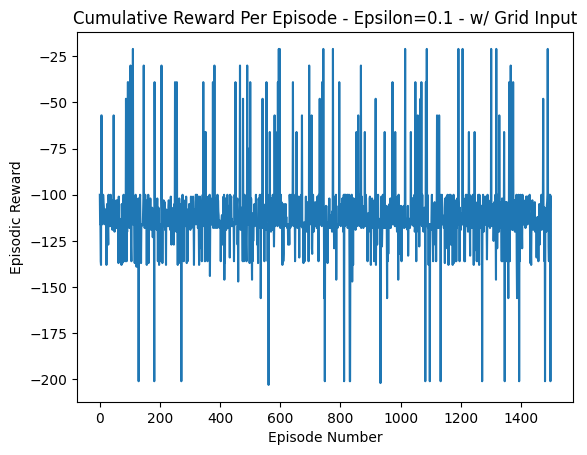

In [ ]:
rewardsTrue = [i for i in rewards]
plt.plot(np.arange(0,numEpochs), rewards)
plt.title("Cumulative Reward Per Episode - Epsilon=0.1 - w/ Grid Input")
plt.xlabel("Episode Number")
plt.ylabel("Episodic Reward")
plt.savefig("/content/output/CumReward-0.8-Grid-10x.")

In [ ]:

torch.save(myAgent.policy_network.state_dict(), "/content/output/pnet.pth")

In [ ]:
!rm -r /content/workspace/00000664-00902292-23HI016730-3-C07-1.ndpi

OrderedDict([('0.0.weight',
              tensor([[[[-0.0102,  0.0179, -0.0166,  ..., -0.0125, -0.0433, -0.0482],
                        [-0.0075, -0.0050,  0.0496,  ..., -0.0456, -0.0099, -0.0499],
                        [ 0.0486, -0.0373, -0.0102,  ...,  0.0312,  0.0430, -0.0105],
                        ...,
                        [-0.0480, -0.0332, -0.0410,  ...,  0.0543,  0.0080,  0.0093],
                        [ 0.0322, -0.0237,  0.0235,  ...,  0.0083,  0.0470,  0.0524],
                        [ 0.0393, -0.0228, -0.0049,  ...,  0.0182,  0.0351,  0.0394]],
              
                       [[-0.0063, -0.0035,  0.0063,  ..., -0.0069,  0.0378, -0.0410],
                        [ 0.0279, -0.0462, -0.0146,  ..., -0.0152, -0.0060,  0.0412],
                        [ 0.0165,  0.0091, -0.0437,  ..., -0.0072, -0.0065,  0.0003],
                        ...,
                        [ 0.0174,  0.0151, -0.0058,  ...,  0.0085, -0.0134, -0.0080],
                        [ 0.0541, -0.0